In [4]:
pip install WordCloud

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
sns.set_style('whitegrid')
from wordcloud import WordCloud

In [2]:
df = pd.read_csv(r"C:\Users\RAHUL BABU KOPPULA\OneDrive\Desktop\Oasis_ infobyte_internship\datasets\spam.csv", encoding='latin-1')[['v1', 'v2']]
df.columns = ['label', 'text']

In [3]:
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
print(df['label'].value_counts())

label
ham     4825
spam     747
Name: count, dtype: int64


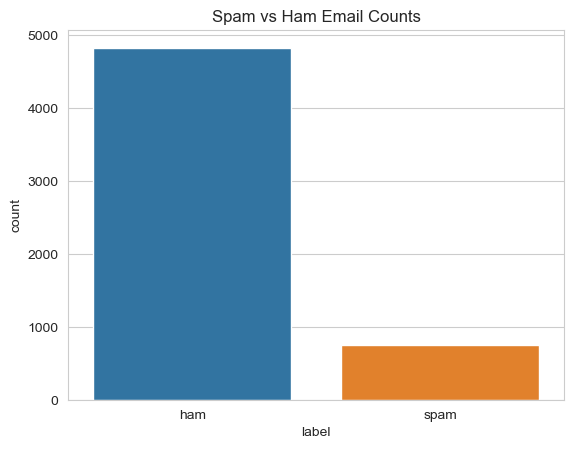

In [5]:
sns.countplot(data=df, x='label')
plt.title('Spam vs Ham Email Counts')
plt.show()

In [7]:
spam_words = " ".join(df[df['label']=='spam']['text'])
ham_words = " ".join(df[df['label']=='ham']['text'])
spam_cloud = WordCloud(width=600, height=400, background_color='black').generate(spam_words)
ham_cloud = WordCloud(width=600, height=400, background_color='white').generate(ham_words)

Text(0.5, 1.0, 'Spam Word Cloud')

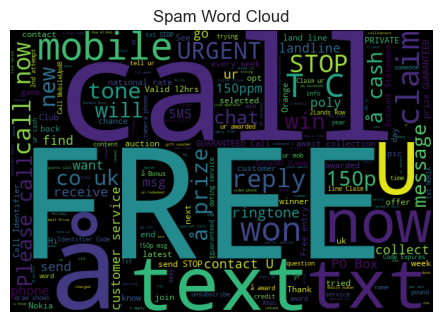

In [8]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.imshow(spam_cloud)
plt.axis('off')
plt.title("Spam Word Cloud")

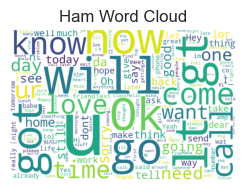

In [9]:
plt.subplot(1, 2, 2)
plt.imshow(ham_cloud)
plt.axis('off')
plt.title("Ham Word Cloud")
plt.show()

In [10]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to C:\Users\RAHUL BABU
[nltk_data]     KOPPULA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

In [12]:
df['clean_text'] = df['text'].apply(clean_text)

In [13]:
df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})

In [14]:
vectorizer = TfidfVectorizer(max_features=3000)
X = vectorizer.fit_transform(df['clean_text']).toarray()
y = df['label_num'].values

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(kernel='linear')
}

In [16]:
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"{name} trained.")

Naive Bayes trained.
Logistic Regression trained.
Random Forest trained.
SVM trained.


In [19]:
 y_pred = model.predict(X_test)
def evaluate_model(model):
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

for name, model in models.items():
    print(f"--- {name} ---")
    evaluate_model(model)
    print("\n")

--- Naive Bayes ---
Accuracy: 0.9802690582959641
Precision: 0.9848484848484849
Recall: 0.8666666666666667
F1 Score: 0.9219858156028369
Confusion Matrix:
 [[963   2]
 [ 20 130]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.98      0.87      0.92       150

    accuracy                           0.98      1115
   macro avg       0.98      0.93      0.96      1115
weighted avg       0.98      0.98      0.98      1115



--- Logistic Regression ---
Accuracy: 0.9802690582959641
Precision: 0.9848484848484849
Recall: 0.8666666666666667
F1 Score: 0.9219858156028369
Confusion Matrix:
 [[963   2]
 [ 20 130]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.98      0.87      0.92       150

    accuracy                           0.98      1115
   macro avg       0.98      0.93      0.

In [21]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20]
}
grid = GridSearchCV(RandomForestClassifier(), param_grid, scoring='f1', cv=5)
grid.fit(X_train, y_train)

print("Best Random Forest Params:", grid.best_params_)

Best Random Forest Params: {'max_depth': None, 'n_estimators': 50}


In [22]:
import joblib
best_model = grid.best_estimator_
joblib.dump(best_model, 'spam_detector_model.pkl')

['spam_detector_model.pkl']

In [23]:
sample_email = ["Congratulations! You've won a free iPhone. Click here."]
sample_clean = [clean_text(email) for email in sample_email]
sample_vector = vectorizer.transform(sample_clean)
prediction = best_model.predict(sample_vector)
print("Prediction (1 = Spam, 0 = Ham):", prediction[0])

Prediction (1 = Spam, 0 = Ham): 0
